<a href="https://colab.research.google.com/github/TheoLequy/HappinessHackers/blob/main/DataAnalysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [57]:
# XGBoost is typically the best for a lot of this kind of stuff (https://dataaspirant.com/xgboost-algorithm/)
# google xgboost kaggle and youll see what i mean
!pip install xgboost
!pip install -U kaleido

import pandas as pd
import numpy as np
from xgboost import XGBRegressor

# Rest of everything we use will probably be sklearn cause its the easiest to use
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, lasso_path
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [2]:
# Clone the github repo with all the data
!git clone https://github.com/TheoLequy/HappinessHackers.git

# Change to this directory
%cd HappinessHackers

# List the files
!ls

fatal: destination path 'HappinessHackers' already exists and is not an empty directory.
/content/HappinessHackers
 data				   'Yearly Happiness vs. Food_insec.png'
 DataAnalysis_ML.ipynb		   'Yearly Happiness vs. Gdppc.png'
 DataProcessing.ipynb		   'Yearly Happiness vs. Gini.png'
 diagramms			   'Yearly Happiness vs. Indiv_libs.png'
 final_dataset_filled.csv	   'Yearly Happiness vs. Life_expect.png'
 final_dataset_raw.csv		   'Yearly Happiness vs. Rain.png'
 final_dataset_raw_region.csv	   'Yearly Happiness vs. School.png'
 final_filled_region.csv	   'Yearly Happiness vs. Suicides.png'
 Plotting.ipynb			   'Yearly Happiness vs. Tax.png'
 README.md			   'Yearly Happiness vs. Urbanization.png'
'Yearly Happiness vs. Covid.png'   'Yearly Happiness vs. War.png'
'Yearly Happiness vs. Family.png'  'Yearly Happiness vs. Yearly temp.png'


# Load Dataset, Fill missing Values

In [105]:
df = pd.read_csv('final_dataset_filled.csv')

# Sets x data to be everything except happiness rank and score
# (country and region are removed because they are non-numeric but could be added in with some proprocessing)
X_with_labels = df.drop(["code", "year", "happiness", "hdi"], axis=1)
y = df["happiness"]

country_labels = df["code"] + ', ' + df["year"].astype(str)

# This cell imputes the data and then scales the data to be normally distributed with mean 0 and standard variance
# helps a lot with linear regression but probs wont make too much of a difference in ensemble methods
# Create a pipeline with imputation and scaling
data_preprocessing = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values using the mean
    ('scaler', StandardScaler())  # Scale data
])

X = data_preprocessing.fit_transform(X_with_labels)
codes = np.array(df["code"].drop_duplicates())
feature_names = X_with_labels.columns

# Linregress + Covariance

In [4]:
s = 20
kf = KFold(n_splits=s, shuffle=True)
mse_in_sample = []
mse_out_sample = []
coefs = pd.DataFrame(columns = X_with_labels.columns)
print(coefs)
X_const = sm.add_constant(X)
i=0
for train_country_index, val_country_index in kf.split(codes):
  # Split the dataset into training and validation sets based on countries
  train_index = df["code"].isin(codes[train_country_index])
  val_index = df["code"].isin(codes[val_country_index])
  X_train, X_val = X_const[train_index], X_const[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = sm.OLS(y_train, X_train)
  res = model.fit()
  mse_in_sample.append(mean_squared_error(res.predict(X_train), y_train))
  mse_out_sample.append(mean_squared_error(res.predict(X_val), y_val))
  coefs.loc[len(coefs.index)]=res.params
  i+=1
in_sample_error = np.mean(mse_in_sample)
out_sample_error = np.mean(mse_out_sample)
avg_coefs = np.mean(coefs, axis=1)
std_coefs = np.std(coefs, axis=1)

print(in_sample_error)
print(out_sample_error)

Empty DataFrame
Columns: [gdppc, urbanization, corruption, food_insec, tax, indiv_libs, school, life_expect, yearly temp, hri, suicides, family, covid, war, hdi, rain, air_pollution, gini]
Index: []
0.32136794595791734
0.396188892289305


In [17]:
# Fit the OLS regression model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

# Get coefficients and standard errors
coefficients = results.params
std_errors = results.bse

# Extract feature names from the list
feature_names = df.columns[3:]

# Create a bar plot with error bars using Plotly
fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_names,
    y=coefficients[1:],
    error_y=dict(type='data', array=std_errors, visible=True),
    marker_color='rgb(26, 118, 255)',
))

fig.update_layout(
    xaxis=dict(title='Features', tickangle=45),
    yaxis=dict(title='Coefficients'),
    width=1200,
    height=600,
    margin=dict(l=20, r=20, t=20, b=20),  # Reduce padding
    showlegend=False,
)

pio.write_image(fig, 'OLS_coefs.png')
fig.show()

# PCA

In [93]:
pcs = [1,2]

pca = PCA(n_components=np.max(pcs))
X_pca = pca.fit_transform(X)

px_data = pd.DataFrame({f'PC {pcs[0]}': X_pca[:, pcs[0]-1], f'PC {pcs[1]}': X_pca[:, pcs[1]-1],
                        'Country': country_labels, 'Happiness': y})

# Create an interactive scatter plot using Plotly
fig = px.scatter(px_data, x=f'PC {pcs[0]}', y=f'PC {pcs[1]}', color='Happiness', hover_data=['Country'])

# Update layout to add axis labels and title
# Configure layout
fig.update_layout(
    height=600,
    width=1200,
    showlegend=True,
    legend_tracegroupgap=240,
    margin=dict(l=20, r=20, t=20, b=20),  # Reduce padding
    xaxis_title=f'Principal Component {pcs[0]}',
    yaxis_title=f'Principal Component {pcs[1]}',
)

pio.write_image(fig, 'Happiness_over_PC1and2.png')
fig.show()

# PCA + Linregress

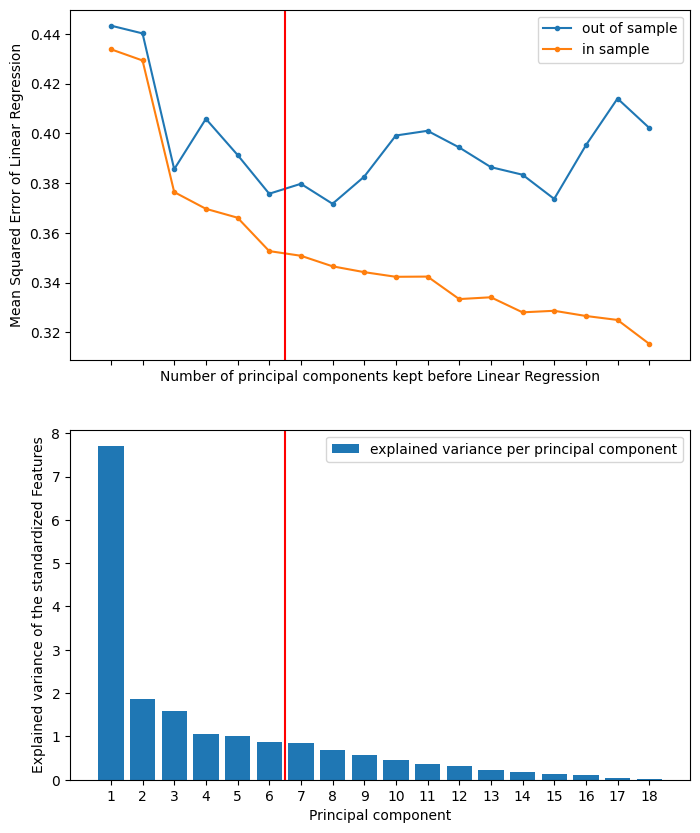

In [77]:
# determining best number of pca components

kf = KFold(n_splits=5, shuffle=True)
n_feat = len(X_with_labels.columns)
n_comps = range(1,n_feat+1)
principal_variance = np.zeros(len(n_comps))
errors = np.ones((len(n_comps), 2))
lin_reg_coefs = np.zeros(n_feat)

for n in n_comps:
  pca = PCA(n_components=n)
  X_pca = pca.fit_transform(X)
  if n == n_feat:
    principal_variance = pca.explained_variance_

  model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[n-1, 0] = np.mean(mse_in_sample)
  errors[n-1, 1] = np.mean(mse_out_sample)



fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,10))
ax1.plot(n_comps, errors[:,1], '.-', label='out of sample')
ax1.plot(n_comps, errors[:,0], '.-', label='in sample')
ax2.bar(n_comps, principal_variance, label='explained variance per principal component')
ax1.set_xlabel("Number of principal components kept before Linear Regression")
ax1.set_ylabel("Mean Squared Error of Linear Regression")
ax1.axvline(6.5, c='r')
ax2.axvline(6.5, c='r')
ax2.set_ylabel("Explained variance of the standardized Features")
ax2.set_xlabel("Principal component")
ax2.set_xticks(n_comps)
ax1.legend()
ax2.legend()

In [78]:
# Create subplots for Mean Squared Error (MSE) and Explained Variance
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)
n_comps = list(n_comps)
# Add traces for Mean Squared Error (MSE)
fig.add_trace(go.Scatter(x=n_comps, y=errors[:,1], mode='lines+markers', name='Out of sample', legendgroup='1'), row=1, col=1)
fig.add_trace(go.Scatter(x=n_comps, y=errors[:,0], mode='lines+markers', name='In sample', legendgroup='1'), row=1, col=1)

# Add trace for Explained Variance
fig.add_trace(go.Bar(x=n_comps, y=principal_variance, name=r'Explained variance <br>per principal component', legendgroup='2'), row=2, col=1)


# Add vertical line at x=6.5
fig.add_vline(x=6.5, line_dash="dash", line_color="black", row="all", col=1)


# Configure layout
fig.update_layout(
    height=600,
    width=1200,
    showlegend=True,
    legend_tracegroupgap=240,
    margin=dict(l=20, r=20, t=20, b=20),  # Reduce padding
)

# Set y-axis labels
fig.update_yaxes(title='Mean Squared Error', row=1, col=1)
fig.update_yaxes(title='Explained variance', row=2, col=1)

# Set x-axis labels and ticks
fig.update_xaxes(title='Principal component', row=2, col=1, tickvals=n_comps)

pio.write_image(fig, 'PCA_LinRegress_Error.png')
fig.show()


Text(0, 0.5, 'coefficient for linear regression with n principal components')

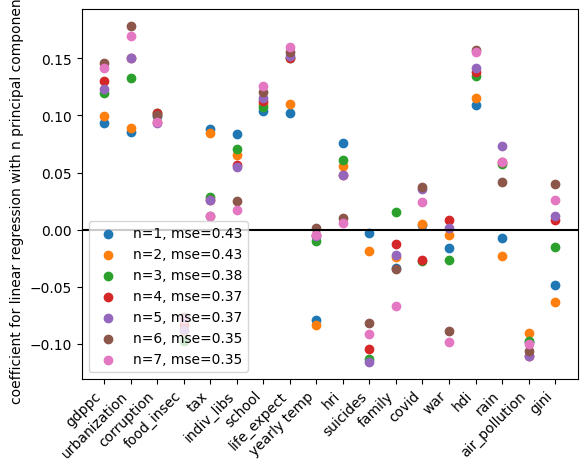

In [8]:
fig, ax = plt.subplots()
ax.axhline(0,c='k')
for n in range(1,8):
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X)

    principal_variance = pca.explained_variance_

    model = LinearRegression() #, XGBRegressor(objective='reg:squarederror', n_estimators=100)]

    model.fit(X_pca, y)

    mse = mean_squared_error(model.predict(X_pca), y)
    expl_var = explained_variance_score(model.predict(X_pca), y)

    lin_reg_coefs = pca.inverse_transform(model.coef_)

    feature_labels = X_with_labels.columns.values
    ax.scatter(feature_labels, lin_reg_coefs, label=f"n={n}, mse={mse:.2f}")


plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel("coefficient for linear regression with n principal components")

# PCA + Polynomial Regression

In [9]:
# determining best number of pca components and degree
deg = 3
kf = KFold(n_splits=5, shuffle=True)
n = 1

pca = PCA(n_components=n)
X_pca = pca.fit_transform(X)

poly = PolynomialFeatures(degree=deg)
X_poly = poly.fit_transform(X)

if n == n_feat:
  principal_variance = pca.explained_variance_

model = Ridge(alpha=1e5)
mse_in_sample = []
mse_out_sample = []
for train_country_index, val_country_index in kf.split(codes):

  # Split the dataset into training and validation sets based on countries
  train_index = df["code"].isin(codes[train_country_index])
  val_index = df["code"].isin(codes[val_country_index])
  X_train, X_val = X_poly[train_index], X_poly[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model.fit(X_train, y_train)

  mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
  mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))



print(np.mean(mse_in_sample))
print(np.mean(mse_out_sample))

0.3986466319016958
0.5715063818139913


# Lasso Regularization

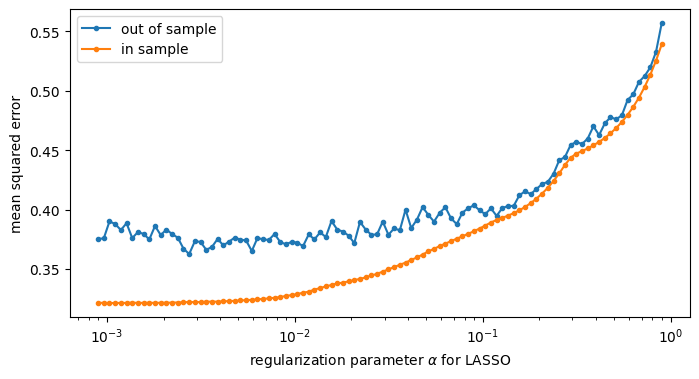

In [63]:
# determining best lasso regularization parameter
s=20
kf = KFold(n_splits=s, shuffle=True)
n_feat = len(X_with_labels.columns)
alphas, coefs_lp, _ = lasso_path(X,y, eps=1e-3)

errors = np.ones((len(alphas), 2))
coefs = pd.DataFrame(columns=feature_names)
for i, a in enumerate(alphas):
  model = Lasso(alpha=a)
  mse_in_sample = []
  mse_out_sample = []
  coef_it = pd.DataFrame(columns=feature_names)
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)
    coef_it.loc[len(coef_it.index)] = model.coef_
    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  coefs.loc[len(coefs.index)] = coef_it.mean()
  errors[i, 0] = np.mean(mse_in_sample)
  errors[i, 1] = np.mean(mse_out_sample)



fig, ax = plt.subplots(figsize=(8,4))
ax.plot(alphas, errors[:,1], '.-', label='out of sample')
ax.plot(alphas, errors[:,0], '.-', label='in sample')
ax.set_xlabel(r"regularization parameter $\alpha$ for LASSO")
ax.set_ylabel("mean squared error")
ax.set_xscale("log")
ax.legend()


In [62]:
# Count the number of zero entries in each series
zero_counts = (coefs == 0).sum()

# Sort the columns based on the number of zero entries (ascending order)
sorted_columns = zero_counts.sort_values().index

Index(['gdppc', 'corruption', 'indiv_libs', 'urbanization', 'food_insec',
       'tax', 'life_expect', 'school', 'family', 'yearly temp', 'war',
       'suicides', 'hri', 'gini', 'covid', 'hdi', 'rain', 'air_pollution'],
      dtype='object')

In [89]:
import plotly.graph_objects as go

# Create subplots for Mean Squared Error (MSE) and Coefficients
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add traces for Mean Squared Error (MSE)
fig.add_trace(go.Scatter(x=alphas, y=errors[:,1], mode='lines',name='out of sample', legendgroup="1"), row=1, col=1)
fig.add_trace(go.Scatter(x=alphas, y=errors[:,0], mode='lines',  name='in sample', legendgroup="1"), row=1, col=1)

# Add traces for Coefficients
line_styles = ['solid', 'longdashdot', 'longdash', 'dash',  'dashdot', 'dot']
rep = int(len(sorted_columns)/len(line_styles))
line_styles = [ls for ls in line_styles for _ in range(rep)]
for feat, ls in zip(sorted_columns, line_styles):
    fig.add_trace(go.Scatter(x=alphas, y=coefs[feat], mode='lines', line=dict(dash=ls), name=feat, legendgroup="2"), row=2, col=1)

# Add vertical line at alpha = 0.1
fig.add_vline(x=0.01, line_dash="dash", line_color="black", row="all", col=1)

# Configure layout
fig.update_layout(
    height=600,
    width=1200,
    showlegend=True,
    legend_tracegroupgap=180,
    margin=dict(l=20, r=20, t=20, b=20),  # Reduce padding
)

fig.update_xaxes(type='log', row=2, col=1)
fig.update_xaxes(type='log', row=1, col=1)

# Set y-axis to logarithmic scale for the upper subplot
fig.update_yaxes(type='log', row=1, col=1)

# Show plot
fig.show()

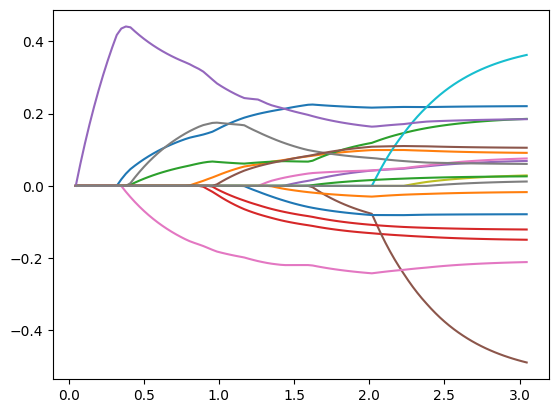

In [87]:
eps = 1e-3
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)


# Display results

plt.figure(1)
neg_log_alphas_lasso = -np.log10(alphas_lasso)
# neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l in coefs_lasso:
    l1 = plt.plot(neg_log_alphas_lasso, coef_l)
    # l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c)


Text(0, 0.5, 'coefficient for LASSO with $\\alpha = 0.1$')

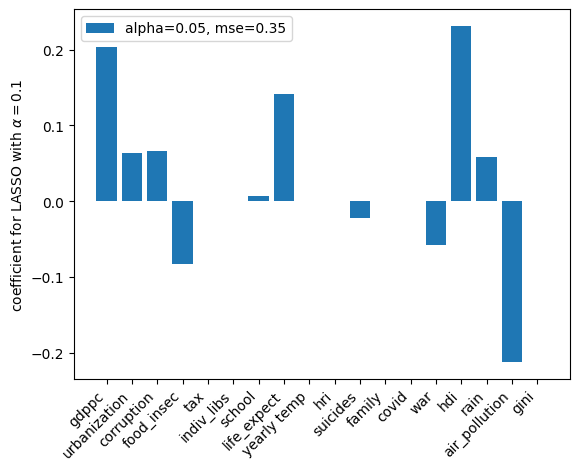

In [96]:
a = 0.05
model = Lasso(alpha=a)
model.fit(X, y)

mse = mean_squared_error(model.predict(X), y)
expl_var = explained_variance_score(model.predict(X), y)

lin_reg_coefs = model.coef_

feature_labels = X_with_labels.columns.values

fig, ax = plt.subplots()
ax.bar(feature_labels, lin_reg_coefs)
plt.xticks(rotation=45, ha='right')
plt.legend()
ax.set_ylabel(r"coefficient for LASSO with $\alpha = 0.1$")



In [109]:
s=5
a = 0.05
coefs = pd.DataFrame(columns=feature_names)
model = Lasso(alpha=a)
mse_in_sample = []
mse_out_sample = []

for _ in range(5):
  kf = KFold(n_splits=s, shuffle=True)
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)
    coefs.loc[len(coefs.index)] = model.coef_
    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))

In [127]:
# Reshape the DataFrame to long format
coefs_long = coefs.melt(var_name='Column', value_name='Value')

# Create a box plot for the values within each column
fig = go.Figure(go.Box(x=coefs_long['Column'], y=coefs_long['Value']))

# Update layout
fig.update_layout(
    xaxis=dict(title='Features'),
    yaxis=dict(title='Coefficients'),
    height=600,
    width=1200,
    margin=dict(l=20, r=20, t=20, b=20),  # Reduce padding
)
pio.write_image(fig, 'Lasso_Coefs.png')
# Show the plot
fig.show()
print(np.mean(mse_in_sample),np.mean(mse_out_sample), np.var(y))

0.3476541717868791 0.4028930554117109 1.2439695228654846


# PCA + XGBoost Trees

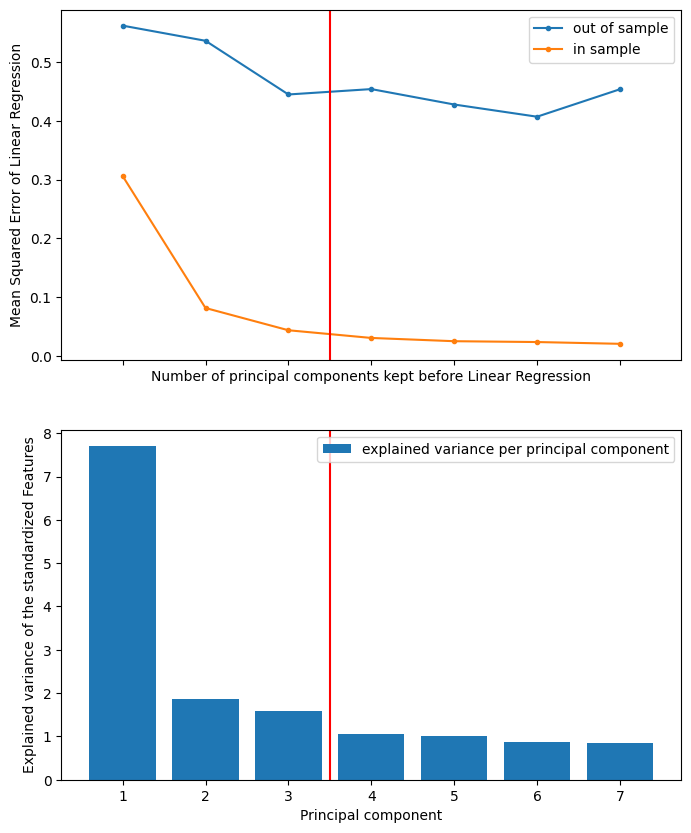

In [12]:
# determining best number of pca components

kf = KFold(n_splits=5, shuffle=True)
n_feat = 7 # len(X_with_labels.columns)
n_comps = range(1,n_feat+1)
principal_variance = np.zeros(len(n_comps))
errors = np.ones((len(n_comps), 2))
lin_reg_coefs = np.zeros(n_feat)

for n in n_comps:
  pca = PCA(n_components=n)
  X_pca = pca.fit_transform(X)
  if n == n_feat:
    principal_variance = pca.explained_variance_

  model = XGBRegressor(objective='reg:squarederror', eta=0.1, n_estimators=100, subsample=0.5)
  mse_in_sample = []
  mse_out_sample = []
  for train_country_index, val_country_index in kf.split(codes):

    # Split the dataset into training and validation sets based on countries
    train_index = df["code"].isin(codes[train_country_index])
    val_index = df["code"].isin(codes[val_country_index])
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)

    mse_in_sample.append(mean_squared_error(model.predict(X_train), y_train))
    mse_out_sample.append(mean_squared_error(model.predict(X_val), y_val))
  errors[n-1, 0] = np.mean(mse_in_sample)
  errors[n-1, 1] = np.mean(mse_out_sample)



fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,10))
ax1.plot(n_comps, errors[:,1], '.-', label='out of sample')
ax1.plot(n_comps, errors[:,0], '.-', label='in sample')
ax2.bar(n_comps, principal_variance, label='explained variance per principal component')
ax1.set_xlabel("Number of principal components kept before Linear Regression")
ax1.set_ylabel("Mean Squared Error of Linear Regression")
ax1.axvline(3.5, c='r')
ax2.axvline(3.5, c='r')
ax2.set_ylabel("Explained variance of the standardized Features")
ax2.set_xlabel("Principal component")
ax2.set_xticks(n_comps)
ax1.legend()
ax2.legend()
